In [1]:
import sys
import importlib
import numpy as np
import mxnet as mx
sys.path.append(r'D:\Documents\PyCharmProjects\ComputerVisionUtils')
import myutils

In [2]:
class DataIter ():
    def __init__ (self, filename):
        self.pos = 0
        
        import os
        windows_dataset_root = r'D:\Documents\Data_Files\Pascal'
        linux_dataset_root = '../Dataset/Pascal'
        self.dataset_root = windows_dataset_root
        self.img_idx_directory = os.path.sep.join([self.dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'ImageSets', 'Main'])
        self.img_directory = os.path.sep.join([self.dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'JPEGImages'])
        self.annotation_directory = os.path.sep.join([self.dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'Annotations'])
        self.filename = filename
        self.class_name = filename.split('_')[0]
    
    def __iter__ (self):
        return self
        
    def __next__ (self):
        # find image and label of specifec class
        import os
        with open (os.path.sep.join([self.img_idx_directory, self.filename]), 'r') as f:
            import re
            regex = re.compile ('[ ]+')
            f.seek(self.pos)
            while (1):
                line = f.readline()
                if line == '':
                    raise StopIteration
                img_idx, in_the_class = regex.split(line.rstrip('\n'))
                in_the_class = int(in_the_class)
                if (in_the_class == 1):
                    self.pos = f.tell()
                    break
                
        
        # read image
        img_path = os.path.sep.join([self.img_directory, img_idx+'.jpg'])
        import mxnet as mx
        img = mx.image.imread(img_path)
        
        # read label from xml file
        import xml.etree.ElementTree as et
        label_path = os.path.sep.join([self.annotation_directory, img_idx+'.xml'])
        tree = et.parse(label_path)
        root = tree.getroot()
        obj_iter = root.iterfind('object')
        for obj in obj_iter:
            if (obj.find('name').text == self.class_name):
                bndbox = obj.find('bndbox')
                coors = mx.nd.array([int(coor.text) for coor in bndbox])
                label = mx.nd.concat(mx.nd.array([1]), coors, dim=0)
                label = label.reshape(shape=(1, 5))
                
        return img.asnumpy(), label.asnumpy()
    
    def reset (self):
        self.pos = 0

data_iter = DataIter('cat_train.txt')
for i, item in enumerate(data_iter):
    pass
print ('total pieces of data:', i+1)
del i, item

img_batch, label_batch = next(myutils.bachify(100, data_iter, myutils.transformer))
print (img_batch.shape)
print (label_batch.shape)
del img_batch, label_batch

total pieces of data: 163
(100, 3, 300, 300)
(100, 1, 5)


In [3]:
ctx = mx.cpu()
linux_model_params_root = '../Parameters'
vgg16 = mx.gluon.model_zoo.vision.vgg16 (pretrained=True, ctx=ctx)

feature_map = vgg16.features[0:30]

feature_map.add (mx.gluon.nn.Conv2D (1024, kernel_size=(3, 3), padding=(1, 1)))
feature_map.add (mx.gluon.nn.Activation('relu'))
feature_map.add (mx.gluon.nn.Conv2D (1024, kernel_size=(1, 1)))
feature_map.add (mx.gluon.nn.Activation('relu'))

feature_map.add (mx.gluon.nn.Conv2D (512, kernel_size=(3, 3), strides=2, padding=(1, 1)))
feature_map.add (mx.gluon.nn.Activation('relu'))

feature_map.add (mx.gluon.nn.Conv2D (256, kernel_size=(3, 3), strides=2, padding=(1, 1)))
feature_map.add (mx.gluon.nn.Activation('relu'))

feature_map.add (mx.gluon.nn.Conv2D (256, kernel_size=(3, 3)))
feature_map.add (mx.gluon.nn.Activation('relu'))

feature_map.add (mx.gluon.nn.Conv2D (256, kernel_size=(3, 3)))
feature_map.add (mx.gluon.nn.Activation('relu'))

feature_map[30:].initialize (init=mx.init.Xavier(), ctx=ctx)

output = feature_map(mx.nd.uniform(0, 1, shape=(1, 3, 300, 300), ctx=ctx))
print (output.shape)

conv4_3 = feature_map[:23]
conv7 = feature_map[:34]
conv8_2 = feature_map[:36]
conv9_2 = feature_map[:38]
conv10_2 = feature_map[:40]
conv11_2 = feature_map[:42]

(1, 256, 1, 1)


In [4]:
class SSDNet (mx.gluon.HybridBlock):
    def __init__ (self, **kwargs):
        super(SSDNet, self).__init__(**kwargs)
        self.anchor_ratios = [1, 2, 0.5]
        self.anchor_sizes = [0.5, 0.25, 0.1]
        with self.name_scope():
            self.feat4_3 = conv4_3
            self.feat7 = conv7
            self.feat8_2 = conv8_2
            self.feat9_2 = conv9_2
            self.feat10_2 = conv10_2
            self.feat11_2 = conv11_2
            
            self.cls_predictor4_3 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)  # 每个位置5个anchors，背景+物体共两个类别
            self.cls_predictor4_3.initialize (mx.init.Xavier(), ctx=ctx)
            self.cls_predictor7 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor7.initialize (mx.init.Xavier(), ctx=ctx)
            self.cls_predictor8_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor8_2.initialize (mx.init.Xavier(), ctx=ctx)
            self.cls_predictor9_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor9_2.initialize (mx.init.Xavier(), ctx=ctx)
            self.cls_predictor10_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor10_2.initialize (mx.init.Xavier(), ctx=ctx)
            self.cls_predictor11_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor11_2.initialize (mx.init.Xavier(), ctx=ctx)
            
            self.bbox_predictor4_3 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor4_3.initialize (mx.init.Xavier(), ctx=ctx)
            self.bbox_predictor7 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor7.initialize (mx.init.Xavier(), ctx=ctx)
            self.bbox_predictor8_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor8_2.initialize (mx.init.Xavier(), ctx=ctx)
            self.bbox_predictor9_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor9_2.initialize (mx.init.Xavier(), ctx=ctx)
            self.bbox_predictor10_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor10_2.initialize (mx.init.Xavier(), ctx=ctx)
            self.bbox_predictor11_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor11_2.initialize (mx.init.Xavier(), ctx=ctx)
            
            
    def forward (self, x):
        feat4_3 = conv4_3(x)
        feat7 = conv7(x)
        feat8_2 = conv8_2(x)
        feat9_2 = conv9_2(x)
        feat10_2 = conv10_2(x)
        feat11_2 = conv11_2(x)
        
        anchors4_3 = mx.nd.contrib.MultiBoxPrior (feat4_3, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors7 = mx.nd.contrib.MultiBoxPrior (feat7, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors8_2 = mx.nd.contrib.MultiBoxPrior (feat8_2, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors9_2 = mx.nd.contrib.MultiBoxPrior (feat9_2, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors10_2 = mx.nd.contrib.MultiBoxPrior (feat10_2, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors11_2 = mx.nd.contrib.MultiBoxPrior (feat11_2, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors = mx.nd.concat (anchors4_3, anchors7, anchors8_2, anchors9_2, anchors10_2, anchors11_2, dim=1)
        
        cls_predictor4_3 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds4_3 = self.cls_predictor4_3 (feat4_3)
        cls_preds4_3 = cls_preds4_3.transpose(axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor7 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds7 = self.cls_predictor7 (feat7)
        cls_preds7 = cls_preds7.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor8_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds8_2 = self.cls_predictor8_2 (feat8_2)
        cls_preds8_2 = cls_preds8_2.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor9_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds9_2 = self.cls_predictor9_2 (feat9_2)
        cls_preds9_2 = cls_preds9_2.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor10_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds10_2 = self.cls_predictor10_2 (feat10_2)
        cls_preds10_2 = cls_preds10_2.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor11_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds11_2 = self.cls_predictor11_2 (feat11_2)
        cls_preds11_2 = cls_preds11_2.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_preds = mx.nd.concat (cls_preds4_3, cls_preds7, cls_preds8_2, cls_preds9_2, cls_preds10_2,
                                  cls_preds11_2, dim=1)
        cls_preds = cls_preds.reshape (shape=(0, -1, 2))
        
        
        bbox_predictor4_3 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds4_3 = self.bbox_predictor4_3 (feat4_3)
        bbox_preds4_3 = bbox_preds4_3.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor7 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds7 = self.bbox_predictor7 (feat7)
        bbox_preds7 = bbox_preds7.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor8_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds8_2 = self.bbox_predictor8_2 (feat8_2)
        bbox_preds8_2 = bbox_preds8_2.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor9_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds9_2 = self.bbox_predictor9_2 (feat9_2)
        bbox_preds9_2= bbox_preds9_2.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor10_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds10_2 = self.bbox_predictor10_2 (feat10_2)
        bbox_preds10_2 = bbox_preds10_2.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor11_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds11_2 = self.bbox_predictor11_2 (feat11_2)
        bbox_preds11_2 = bbox_preds11_2.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_preds = mx.nd.concat (bbox_preds4_3, bbox_preds7, bbox_preds8_2, bbox_preds9_2,
                                   bbox_preds10_2, bbox_preds11_2, dim=1)
        
        return anchors, cls_preds, bbox_preds
    
net = SSDNet()
net.hybridize()
anchors, cls_preds, bbox_preds = net(mx.nd.uniform(0, 1, shape=(1, 3, 300, 300), ctx=ctx))
print ('anchors:', anchors.shape)
print ('cls_preds:', cls_preds.shape)
print ('bbox_preds:', bbox_preds.shape)

anchors: (1, 9045, 4)
cls_preds: (1, 9045, 2)
bbox_preds: (1, 36180)


In [25]:
cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
bbox_loss = mx.gluon.loss.L1Loss()
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum':0.05})

In [23]:
trainer.set_learning_rate(0.05)

In [29]:
batch_size = 5
data_iter.reset()
data, label = myutils.get_data_n(data_iter, 1)
data, label = myutils.resize_img_and_label(data, label)
data = mx.img.color_normalize(src=mx.nd.array(data), mean=mx.nd.array(myutils.mean), std=mx.nd.array(myutils.std))
data = myutils.to_tensor(data)
data = data.expand_dims(axis=0)
label = mx.nd.array(label)
label = label.expand_dims(axis=0)

print (data.shape)
print (label.shape)

for batch in range(20):
#     img_batch, label_batch = next(myutils.bachify(batch_size, data_iter, myutils.transformer))
#     data = img_batch.as_in_context(ctx)
#     label = label_batch.as_in_context(ctx)

    with mx.autograd.record():
        anchors, cls_preds, bbox_preds = net(data)
        bbox_labels, bbox_masks, cls_labels = mx.nd.contrib.MultiBoxTarget (anchors.as_in_context(mx.cpu()),
                                                                            label.as_in_context(mx.cpu()),
                                                                            cls_preds.transpose((0, 2, 1)).as_in_context(mx.cpu()))
        bbox_labels = bbox_labels.as_in_context(ctx)
        bbox_masks = bbox_masks.as_in_context(ctx)
        cls_labels = cls_labels.as_in_context(ctx)

        batch_cls_loss = cls_loss (cls_preds, cls_labels)
        batch_bbox_loss = bbox_loss (bbox_preds * bbox_masks, bbox_labels * bbox_masks)
        batch_loss = 0.5 * batch_cls_loss + batch_bbox_loss

    batch_loss.backward()
    trainer.step(1)

    print ('batch', str(batch)+':', batch_loss.mean().asscalar())

(1, 3, 300, 300)
(1, 1, 5)
batch 0: 0.00013918306
batch 1: 0.00013713932
batch 2: 0.00013523913
batch 3: 0.00013337079
batch 4: 0.0001315481
batch 5: 0.00012974786
batch 6: 0.00012798465
batch 7: 0.00012625127
batch 8: 0.00012455136
batch 9: 0.00012287873
batch 10: 0.00012124021
batch 11: 0.00011963158
batch 12: 0.000118048025
batch 13: 0.00011648549
batch 14: 0.00011495713
batch 15: 0.00011344793
batch 16: 0.000111975416
batch 17: 0.00011051512
batch 18: 0.00010909951
batch 19: 0.00010769584


In [138]:
net.save_parameters('batch_loss_0_043567013')


[[0.         0.3183252  0.21302941 0.3401959  0.7917845  0.6346532 ]
 [0.         0.29363564 0.3061878  0.         0.6567294  0.90194774]
 [0.         0.26764145 0.43969357 0.46358186 0.53025836 0.55083233]
 [0.         0.17606987 0.3366325  0.35417616 0.6445618  0.6710726 ]
 [0.         0.02309671 0.12558626 0.7717521  0.20805494 0.8683753 ]
 [0.         0.02097498 0.73261344 0.55891764 1.         1.        ]
 [0.         0.01917164 0.8596618  0.03291302 1.         0.20239255]
 [0.         0.01541584 0.80268097 0.2450349  1.         0.8160398 ]
 [0.         0.01513182 0.         0.00138035 0.24202149 0.3554426 ]
 [0.         0.01398938 0.89688015 0.07865943 0.9561769  0.15807779]
 [0.         0.01205618 0.         0.         0.21829286 0.1652416 ]
 [0.         0.01185877 0.11029114 0.0507285  0.29147166 0.6165549 ]
 [0.         0.01097388 0.52556384 0.02893096 1.         0.4807325 ]
 [0.         0.0108945  0.         0.9194774  0.08523665 1.        ]
 [0.         0.0107872  0.5138277

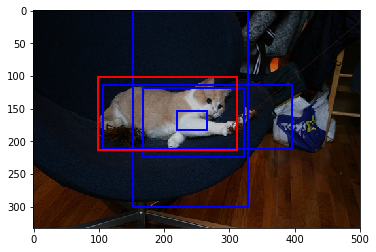

In [30]:
myutils.validate_data_n(1, data_iter=data_iter, net=net, the_first_n_bboxes=4)

In [5]:
net.load_parameters('30_batch_parameters')

In [2]:
import gluoncv as gcv
net2 = gcv.model_zoo.ssd_512_resnet50_v1_voc(pretrained=True)

C:\IntelPython3\lib\site-packages\mxnet\gluon\block.py:421: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


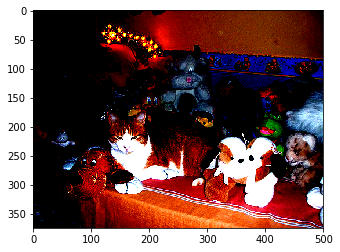

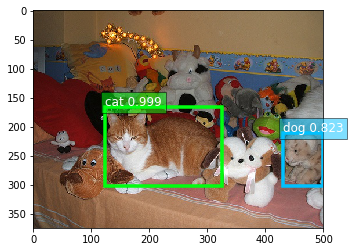

In [79]:
img_val, label_val = myutils.get_data_n(data_iter=data_iter, n=30)
mx_img_val = img_val.astype('float32')/255
mx_img_val = mx.nd.array(mx_img_val)
mx_img_val = mx.img.color_normalize(mx_img_val, mx.nd.array(myutils.mean), mx.nd.array(myutils.std))
mx_img_val = myutils.to_tensor(mx_img_val)
mx_img_val = mx_img_val.expand_dims(axis=0)
plt.imshow(mx_img_val[0].transpose(axes=(1, 2, 0)).asnumpy())
plt.show()

output = net2(mx_img_val)
out_1, out_2, out_3 = output
ax = gcv.utils.viz.plot_bbox(img_val, out_3[0], out_2[0],
                         out_1[0], class_names=net2.classes, thresh=0.5)
plt.show()

In [50]:
myutils.validate_data_n(8, data_iter, net=net2, the_first_n_bboxes=3)

MXNetError: [00:13:48] c:\jenkins\workspace\mxnet\mxnet\src\operator\contrib\multibox_detection-inl.h:159: Check failed: lshape.ndim() == 2U (3 vs. 2) Provided: [1,100,4]